In [1]:
### TEMP 



# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_colwidth', None)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from matplotlib import pyplot as plt
import seaborn as sns

from google.cloud import bigquery
import datetime

import warnings
warnings.filterwarnings('ignore')



# function for safe queries (based on Kaggle SQL course)
def querytodf(query):
    dry_run_config = bigquery.QueryJobConfig(dry_run=True)

    # API request - dry run query to estimate costs
    dry_run_query_job = client.query(query, job_config=dry_run_config)
    print("This query will process {} bytes.".format(dry_run_query_job.total_bytes_processed))

    # Only run the query if it's less than 1 GB
    ONE_GB = 1000*1000*1000
    safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=ONE_GB)

    # Set up the query (will only run if it's less than 1 GB)
    safe_query_job = client.query(query, job_config=safe_config)

    return safe_query_job.to_dataframe()

# get 'bls' dataset
client = bigquery.Client()
dataset_ref = client.dataset("bls", project="bigquery-public-data")
dataset = client.get_dataset(dataset_ref)



# check column info for CES series table
table_ref = dataset_ref.table('employment_hours_earnings_series')
table = client.get_table(table_ref)



# supersector codes
url = 'https://download.bls.gov/pub/time.series/ce/ce.supersector'
dfss = pd.read_csv(url, sep='\t')
display(table.schema[1], '', dfss)

# industry codes
url = 'https://download.bls.gov/pub/time.series/ce/ce.industry'
dfi = pd.read_csv(url, sep='\t')
display(table.schema[2], '', dfi)

# datatype codes
url = 'https://download.bls.gov/pub/time.series/ce/ce.datatype'
dft = pd.read_csv(url, sep='\t')
display(table.schema[3], '', dft)

Using Kaggle's public dataset BigQuery integration.


SchemaField('supersector_code', 'INTEGER', 'NULLABLE', 'Code identifying the super sector.', (), None)

''

,supersector_code,supersector_name
0,0,Total nonfarm
1,5,Total private
2,6,Goods-producing
3,7,Service-providing
4,8,Private service-providing
5,10,Mining and logging
6,20,Construction
7,30,Manufacturing
8,31,Durable Goods
9,32,Nondurable Goods


SchemaField('industry_code', 'INTEGER', 'NULLABLE', 'Code identifying industry.', (), None)

''

,industry_code,naics_code,publishing_status,industry_name,display_level,selectable,sort_sequence
0,0,-,B,Total nonfarm,0,T,1
1,5000000,-,A,Total private,1,T,2
2,6000000,-,A,Goods-producing,1,T,3
3,7000000,-,B,Service-providing,1,T,4
4,8000000,-,A,Private service-providing,1,T,5
...,...,...,...,...,...,...,...
874,90932221,-,B,Local government utilities,5,T,875
875,90932480,-,B,Local government transportation,5,T,876
876,90932622,-,B,Local hospitals,5,T,877
877,90932920,-,B,Local government general administration,5,T,878


SchemaField('data_type_code', 'INTEGER', 'NULLABLE', 'Code identifying the datatype of the observation.', (), None)

''

,data_type_code,data_type_text
0,1,"ALL EMPLOYEES, THOUSANDS"
1,2,AVERAGE WEEKLY HOURS OF ALL EMPLOYEES
2,3,AVERAGE HOURLY EARNINGS OF ALL EMPLOYEES
3,4,AVERAGE WEEKLY OVERTIME HOURS OF ALL EMPLOYEES
4,6,"PRODUCTION AND NONSUPERVISORY EMPLOYEES, THOUSANDS"
5,7,AVERAGE WEEKLY HOURS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES
6,8,AVERAGE HOURLY EARNINGS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES
7,9,AVERAGE WEEKLY OVERTIME HOURS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES
8,10,"WOMEN EMPLOYEES, THOUSANDS"
9,11,AVERAGE WEEKLY EARNINGS OF ALL EMPLOYEES


In [22]:
(
    dfi
    .groupby('industry_name')
    .publishing_status.unique()
    .reset_index()
)

,industry_name,publishing_status
0,"AC, refrigeration, and forced air heating",[C]
1,Accommodation,[A]
2,Accommodation and food services,[A]
3,Accounting and bookkeeping services,[A]
4,Activities related to credit intermediation,[A]
...,...,...
867,Women's clothing stores,[A]
868,Wood containers and pallets,[ET]
869,Wood kitchen cabinets and countertops,[AO]
870,Wood products,[AO]


In [315]:
display(plt.style.available)

plt.style.use('default')

plt.style.use('fivethirtyeight')
# plt.style.use('seaborn-whitegrid')
# plt.style.use('seaborn-white')

plt.style.use('seaborn-notebook')

# sns.set_palette('tab20')
# sns.set_palette('Set2')

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

# How did COVID-19 Impact the U.S. Labor Market?
# How is the U.S. Labor Market Recovering from COVID-19?

This notebook is inspired by some of the findings here:

https://www.kaggle.com/heisxiang/are-price-levels-increasing-faster-than-wages

namely that average wages rose dramatically during the onset of Covid-19

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_colwidth', None)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from matplotlib import pyplot as plt
import seaborn as sns

from google.cloud import bigquery
import datetime

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# function for safe queries (based on Kaggle SQL course)
def querytodf(query):
    dry_run_config = bigquery.QueryJobConfig(dry_run=True)

    # API request - dry run query to estimate costs
    dry_run_query_job = client.query(query, job_config=dry_run_config)
    print("This query will process {} bytes.".format(dry_run_query_job.total_bytes_processed))

    # Only run the query if it's less than 1 GB
    ONE_GB = 1000*1000*1000
    safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=ONE_GB)

    # Set up the query (will only run if it's less than 1 GB)
    safe_query_job = client.query(query, job_config=safe_config)

    return safe_query_job.to_dataframe()

# get 'bls' dataset
client = bigquery.Client()
dataset_ref = client.dataset("bls", project="bigquery-public-data")
dataset = client.get_dataset(dataset_ref)

# Examine Dataset
Explore the data to find what we want to query

Available tables:

In [ ]:
# list of tables
tables = client.list_tables(dataset_ref)
for table in tables: print(table.table_id)

Column info and first 5 rows of `employment_hours_earnings` table:

In [ ]:
# check column info for CES table
table_ref = dataset_ref.table('employment_hours_earnings')
table = client.get_table(table_ref)
display(table.schema)

# show first 5 rows
client.list_rows(table, max_results=5).to_dataframe()

Each set of time series data has a corresponding `series_id` and `series_title`. We need to find the relevant `series_id`'s that will help answer our question. To do this we'll examine the `employment_hours_earnings_series` table which has additional info about each `series_id`.

Column info and first 5 rows of `employment_hours_earnings_series` table:

In [ ]:
# check column info for CES series table
table_ref = dataset_ref.table('employment_hours_earnings_series')
table = client.get_table(table_ref)
display(table.schema)

# show first 5 rows
client.list_rows(table, max_results=5).to_dataframe()

We can see that each `series_id` corresponds with a number of codes describing its data. We'll explore the possible values of each code and cherry pick the ones relevant to our analysis. Files from https://download.bls.gov/pub/time.series/ce/

`supersector_code`:

In [ ]:
url = 'https://download.bls.gov/pub/time.series/ce/ce.supersector'
dfss = pd.read_csv(url, sep='\t')
display(table.schema[1], '', dfss)

`industry_code`:

In [ ]:
url = 'https://download.bls.gov/pub/time.series/ce/ce.industry'
dfi = pd.read_csv(url, sep='\t')
display(table.schema[2], '', dfi)

In [ ]:
df.head(25)

`data_type_code`:

In [ ]:
url = 'https://download.bls.gov/pub/time.series/ce/ce.datatype'
dft = pd.read_csv(url, sep='\t')
display(table.schema[3], '', dft)

`seasonal`:

In [ ]:
url = 'https://download.bls.gov/pub/time.series/ce/ce.seasonal'
df = pd.read_csv(url, sep='\t')
display(table.schema[4], '', df)

`footnote_codes`:

In [ ]:
url = 'https://download.bls.gov/pub/time.series/ce/ce.footnote'
df = pd.read_csv(url, sep='\t')
display(table.schema[6], '', df)

There is a lot of available data, the bls.gov website provides explanations here: https://www.bls.gov/web/empsit/cestn.htm

We'll filter the data mainly by `data_type_code`. Relevant data types for this analysis:
* 1	ALL EMPLOYEES, THOUSANDS
* 2	AVERAGE WEEKLY HOURS OF ALL EMPLOYEES
* 3	AVERAGE HOURLY EARNINGS OF ALL EMPLOYEES
* 6	PRODUCTION AND NONSUPERVISORY EMPLOYEES, THOUSANDS
* 7	AVERAGE WEEKLY HOURS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES
* 8	AVERAGE HOURLY EARNINGS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES
* 11	AVERAGE WEEKLY EARNINGS OF ALL EMPLOYEES
* 30	AVERAGE WEEKLY EARNINGS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES
* 56	AGGREGATE WEEKLY HOURS OF ALL EMPLOYEES, THOUSANDS
* 57	AGGREGATE WEEKLY PAYROLLS OF ALL EMPLOYEES, THOUSANDS
* 81	AGGREGATE WEEKLY HOURS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES, THOUSANDS
* 82	AGGREGATE WEEKLY PAYROLLS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES, THOUSANDS

from `ce.text` located at https://download.bls.gov/pub/time.series/ce/:
<PRE> </PRE>
asdfasdfasdf

# Query + Prep Data

In [2]:
query = """ 
SELECT 
    ces.series_id, 
    ces_s.data_type_code, 
    ces_s.supersector_code, 
    ces_s.industry_code, 
    ces.footnote_codes, 
    ces.year, 
    ces.period, 
    ces.date, 
    ces.value
FROM `bigquery-public-data.bls.employment_hours_earnings` ces
INNER JOIN `bigquery-public-data.bls.employment_hours_earnings_series` ces_s
    ON ces.series_id = ces_s.series_id
WHERE ces_s.data_type_code IN (1,2,3,6,7,8,11,30,56,57,81,82)
AND ces_s.seasonal = 'S'
AND EXTRACT(YEAR FROM ces.date) >= 1997
ORDER BY ces.series_id, ces.date
"""

data = querytodf(query)

This query will process 351425379 bytes.


In [3]:
# clean data

data['data_type_code'] = data['data_type_code'].replace(list(dft.data_type_code), 
                                                        list(dft.data_type_text))
data['supersector_code'] = data['supersector_code'].replace(list(dfss.supersector_code), 
                                                            list(dfss.supersector_name))
data['industry_code'] = data['industry_code'].replace(list(dfi.industry_code), 
                                                      list(dfi.industry_name))
data.rename(columns = {'data_type_code': 'data_type', 
                       'supersector_code': 'supersector', 
                       'industry_code': 'industry'}, 
            inplace=True)
display(data)

,series_id,data_type,supersector,industry,footnote_codes,year,period,date,value
0,CES0000000001,"ALL EMPLOYEES, THOUSANDS",Total nonfarm,Total nonfarm,None,1997,M01,1997-01-01,121363.0
1,CES0000000001,"ALL EMPLOYEES, THOUSANDS",Total nonfarm,Total nonfarm,None,1997,M02,1997-02-01,121675.0
2,CES0000000001,"ALL EMPLOYEES, THOUSANDS",Total nonfarm,Total nonfarm,None,1997,M03,1997-03-01,121990.0
3,CES0000000001,"ALL EMPLOYEES, THOUSANDS",Total nonfarm,Total nonfarm,None,1997,M04,1997-04-01,122286.0
4,CES0000000001,"ALL EMPLOYEES, THOUSANDS",Total nonfarm,Total nonfarm,None,1997,M05,1997-05-01,122546.0
...,...,...,...,...,...,...,...,...,...
1694502,CES9093299901,"ALL EMPLOYEES, THOUSANDS",Government,Other local government,None,2020,M11,2020-11-01,955.2
1694503,CES9093299901,"ALL EMPLOYEES, THOUSANDS",Government,Other local government,None,2020,M12,2020-12-01,946.0
1694504,CES9093299901,"ALL EMPLOYEES, THOUSANDS",Government,Other local government,None,2021,M01,2021-01-01,943.3
1694505,CES9093299901,"ALL EMPLOYEES, THOUSANDS",Government,Other local government,None,2021,M02,2021-02-01,946.2


In [4]:
# make slicing data easier

types = pd.Series(data.data_type.unique())
display(types)

sectors = pd.Series(data.supersector.unique())
display(sectors)

industries = data.industry.unique()
# display(industries)

0                                                            ALL EMPLOYEES, THOUSANDS
1                                               AVERAGE WEEKLY HOURS OF ALL EMPLOYEES
2                                            AVERAGE HOURLY EARNINGS OF ALL EMPLOYEES
3                                  PRODUCTION AND NONSUPERVISORY EMPLOYEES, THOUSANDS
4                     AVERAGE WEEKLY HOURS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES
5                  AVERAGE HOURLY EARNINGS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES
6                                            AVERAGE WEEKLY EARNINGS OF ALL EMPLOYEES
7                  AVERAGE WEEKLY EARNINGS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES
8                                  AGGREGATE WEEKLY HOURS OF ALL EMPLOYEES, THOUSANDS
9                               AGGREGATE WEEKLY PAYROLLS OF ALL EMPLOYEES, THOUSANDS
10       AGGREGATE WEEKLY HOURS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES, THOUSANDS
11    AGGREGATE WEEKLY PAYROLLS OF PRODUCTION AND NONS

0                            Total nonfarm
1                            Total private
2                          Goods-producing
3                        Service-providing
4                Private service-providing
5                       Mining and logging
6                             Construction
7                            Manufacturing
8                            Durable Goods
9                         Nondurable Goods
10    Trade, transportation, and utilities
11                         Wholesale trade
12                            Retail trade
13          Transportation and warehousing
14                               Utilities
15                             Information
16                    Financial activities
17      Professional and business services
18           Education and health services
19                 Leisure and hospitality
20                          Other services
21                              Government
dtype: object

# EDA

In [5]:
display(
    data.info(), '',
    'nunique series_id:', data.series_id.nunique(), '', 
    'min dates:', data.groupby('series_id').date.min().value_counts(), '',
    'max dates:', data.groupby('series_id').date.max().value_counts(), '', 
    'series per data_type:', data.groupby('data_type').series_id.nunique().sort_values(), '', 
    'series per supersector:', data.groupby('supersector').series_id.nunique().sort_values(), '',
    'series per industry:', data.groupby('industry').series_id.nunique().sort_values(), '',
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1694507 entries, 0 to 1694506
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   series_id       object 
 1   data_type       object 
 2   supersector     object 
 3   industry        object 
 4   footnote_codes  object 
 5   year            int64  
 6   period          object 
 7   date            object 
 8   value           float64
dtypes: float64(1), int64(1), object(7)
memory usage: 116.4+ MB


None

''

'nunique series_id:'

6965

''

'min dates:'

1997-01-01    3929
2006-03-01    3010
2003-01-01      24
2001-01-01       2
Name: date, dtype: int64

''

'max dates:'

2021-03-01    6349
2021-04-01     616
Name: date, dtype: int64

''

'series per data_type:'

data_type
AGGREGATE WEEKLY HOURS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES, THOUSANDS       514
AGGREGATE WEEKLY PAYROLLS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES, THOUSANDS    514
AVERAGE HOURLY EARNINGS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES                 514
AVERAGE WEEKLY EARNINGS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES                 514
AVERAGE WEEKLY HOURS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES                    514
PRODUCTION AND NONSUPERVISORY EMPLOYEES, THOUSANDS                                 514
AGGREGATE WEEKLY HOURS OF ALL EMPLOYEES, THOUSANDS                                 602
AGGREGATE WEEKLY PAYROLLS OF ALL EMPLOYEES, THOUSANDS                              602
AVERAGE HOURLY EARNINGS OF ALL EMPLOYEES                                           602
AVERAGE WEEKLY EARNINGS OF ALL EMPLOYEES                                           602
AVERAGE WEEKLY HOURS OF ALL EMPLOYEES                                              602
ALL EMPLOYEES, THOUSANDS         

''

'series per supersector:'

supersector
Total nonfarm                             1
Service-providing                         1
Trade, transportation, and utilities     12
Total private                            12
Goods-producing                          12
Manufacturing                            12
Private service-providing                12
Government                               21
Utilities                                87
Mining and logging                      143
Information                             194
Transportation and warehousing          326
Leisure and hospitality                 423
Nondurable Goods                        442
Construction                            472
Other services                          487
Education and health services           571
Financial activities                    584
Wholesale trade                         585
Retail trade                            742
Professional and business services      900
Durable Goods                           926
Name: series_id, dty

''

'series per industry:'

industry
AC, refrigeration, and forced air heating                     1
Government                                                    1
Rail transportation                                           1
Railroad rolling stock and other transportation equipment     1
Glass containers and products made of purchased glass         1
                                                             ..
Chemicals                                                    24
Motor vehicles and parts                                     24
Motor vehicles                                               24
Paper and paper products                                     24
Durable goods                                                24
Name: series_id, Length: 864, dtype: int64

''

In [11]:
# check for missing months
s = data.groupby('series_id').period.value_counts().rename('period_counts').to_frame().reset_index()
display(s)
s2 = s.groupby('series_id').period_counts.max() - s.groupby('series_id').period_counts.min()
s2.value_counts() # max should be 1

,series_id,period,period_counts
0,CES0000000001,M01,25
1,CES0000000001,M02,25
2,CES0000000001,M03,25
3,CES0000000001,M04,25
4,CES0000000001,M05,24
...,...,...,...
83575,CES9093299901,M08,24
83576,CES9093299901,M09,24
83577,CES9093299901,M10,24
83578,CES9093299901,M11,24


1    6965
Name: period_counts, dtype: int64

# How did COVID-19 Impact the U.S. Labor Market?

### Outline
Definitions from https://www.bls.gov/web/empsit/cestn.htm#section5:

Basic data types:
* Total employees
* Total weekly payroll
* Total weekly hours

Derived data types:
* Average weekly hours = total weekly hours / total employees
* Average hourly earnings = total weekly payroll / total weekly hours
* Average weekly earnings = average hourly earnings * average weekly hours (total weekly payroll / total employees)

Hypothesis:
* Many of the people who lost their jobs during COVID-19 were relatively lower wage earners, thus leaving relatively higher wage earners in the payroll data, driving average wages higher.

Method: 

Compare pre vs during COVID-19 numbers for each of the datatypes

**Total private sector**
* AHE vs AWE
* Basic Data
    * All employees vs non-supervisory
    * abs vs pct
* AWH: total hours vs total employees
* AHE: payroll vs total hours
* AWE: AHE vs AWH
* AWE: payroll vs total employees

**by industry:**
* Basic data: change by industry (tiered by average earnings pre-covid)
* Hours change?

In [7]:
types[[2,3]].values

array(['AVERAGE HOURLY EARNINGS OF ALL EMPLOYEES',
       'PRODUCTION AND NONSUPERVISORY EMPLOYEES, THOUSANDS'], dtype=object)

### Total Private Sector

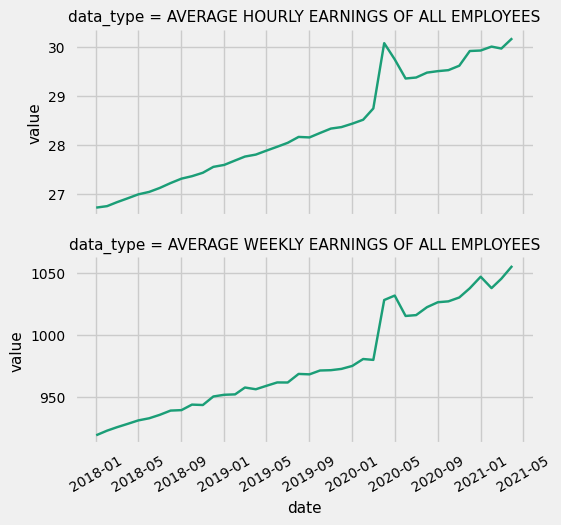

In [311]:
# average hourly earnings vs average weekly earnings

dates = data.year >= 2018
TP = data.supersector == sectors[1]
hourly = data.data_type == types[2]
weekly = data.data_type == types[6]

sns.relplot(data=data[dates&TP&(hourly|weekly)], x='date', y='value', kind='line', 
            row='data_type', 
            aspect=2.25, height=2.5,
            facet_kws=dict(sharey=False)
           )
plt.xticks(rotation=30);

* Basic Data
    * All employees vs non-supervisory
    * abs vs pct

In [206]:
sectors[5]

'Mining and logging'

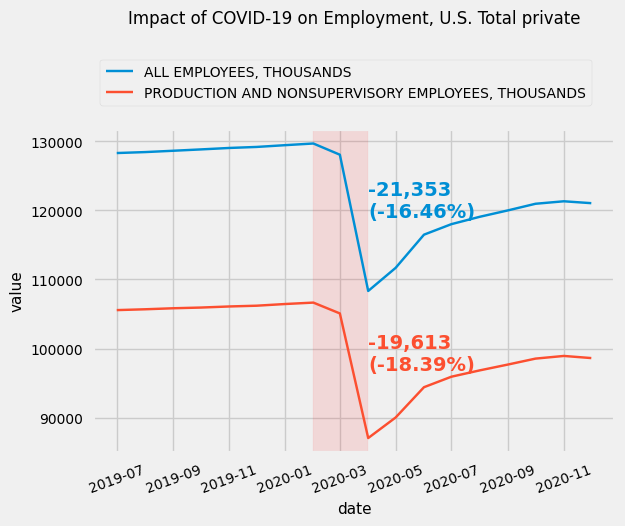

In [318]:
sector = sectors[1]
typ = types[[0,3]].values

cdate1 = (data.date >= datetime.date(2019,7,1))
cdate2 = (data.date <= datetime.date(2020,12,1))
ctype = (data.data_type.isin(typ))
csector = (data.supersector == sector)

dfog = data[cdate1&cdate2&ctype&csector]
df = dfog.groupby(['data_type', 'date']).value.sum().reset_index()

df0 = df[df.data_type == typ[0]]
max0 = df0.value.max()
diff0 = df0.value.max() - df0.value.min()

df1 = df[df.data_type == typ[1]]
max1 = df1.value.max()
diff1 = df1.value.max() - df1.value.min()

plt.figure(figsize=(6,4))
sns.lineplot(data=df, x='date', y='value', hue='data_type',)
plt.title('Impact of COVID-19 on Employment, U.S. '+sector, y=1.3)
plt.legend(loc='lower left', bbox_to_anchor=(0,1.05))

plt.axvspan(datetime.date(2020,2,1), datetime.date(2020,4,1), 
            color='red', alpha=0.1)

plt.text(datetime.date(2020,4,1), max0-diff0/2, 
         str('{:,}'.format(round(-diff0)))+'\n({:.2%})'.format(-diff0/max0),
         color = sns.color_palette()[0],
         weight='bold')
plt.text(datetime.date(2020,4,1), max1-diff1/2, 
         str('{:,}'.format(round(-diff1)))+'\n({:.2%})'.format(-diff1/max1),
         color = sns.color_palette()[1],
         weight='bold')

plt.xticks(rotation=20);

In [306]:
sns.set_palette('Dark2')

In [219]:
s = df.groupby(['data_type', 'date']).value.sum().to_frame().reset_index()
s[s.data_type == typ[0]]


,data_type,date,value
0,"ALL EMPLOYEES, THOUSANDS",2019-07-01,2811.8
1,"ALL EMPLOYEES, THOUSANDS",2019-08-01,2779.9
2,"ALL EMPLOYEES, THOUSANDS",2019-09-01,2776.0
3,"ALL EMPLOYEES, THOUSANDS",2019-10-01,2778.8
4,"ALL EMPLOYEES, THOUSANDS",2019-11-01,2736.4
5,"ALL EMPLOYEES, THOUSANDS",2019-12-01,2689.9
6,"ALL EMPLOYEES, THOUSANDS",2020-01-01,2674.6
7,"ALL EMPLOYEES, THOUSANDS",2020-02-01,2676.7
8,"ALL EMPLOYEES, THOUSANDS",2020-03-01,2614.8
9,"ALL EMPLOYEES, THOUSANDS",2020-04-01,2407.4


In [228]:
df0.value.max()-df0.value.min()

1406.0

In [223]:
display(max0)
display(max1)

2811.8

1832.1

In [323]:
sns.color_palette('tab10_r')

[(0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

In [316]:
sns.color_palette()

[(0.0, 0.5607843137254902, 0.8352941176470589),
 (0.9882352941176471, 0.30980392156862746, 0.18823529411764706),
 (0.8980392156862745, 0.6823529411764706, 0.2196078431372549),
 (0.42745098039215684, 0.5647058823529412, 0.30980392156862746),
 (0.5450980392156862, 0.5450980392156862, 0.5450980392156862),
 (0.5058823529411764, 0.058823529411764705, 0.48627450980392156)]

In [ ]:
dates = data.year >= 2018
TP = data.supersector == sectors[1]
AWP = data.data_type == datatypes[9]
AWH = data.data_type == datatypes[8]
df = data[dates&TP&(AWP|AWH)]
display(df)

# convert to wide format
dfW = df.pivot(index='date',columns='data_type', values='value')
dfW

In [ ]:
dfW.columns

In [ ]:
dfW['AHE'] = dfW[dfW.columns[1]]/dfW[dfW.columns[0]]
dfW

In [ ]:
sns.lineplot(x=dfW.index, y=dfW['AHE']);

In [ ]:
totals = [a for a in datatypes if 'THOUSANDS' in a]
display(totals)

AE = data.data_type == totals[3]
NSE = data.data_type == totals[5]
df = data[dates&TP&(AE|NSE)]
display(df)

# convert to wide format
dfW = df.pivot(index='date',columns='data_type', values='value')
# display(dfW)

dfW['SUPERVISORY EMPLOYEES, THOUSANDS'] = dfW[dfW.columns[0]] - dfW[dfW.columns[1]]
# display(dfW)
display(dfW.iloc[:,1:])
plt.stackplot(dfW.index, dfW[dfW.columns[2]], dfW[dfW.columns[1]])
plt.xticks(rotation=30);

In [ ]:
# supervisory employees (all minus non-sup)

cA = (data.data_type == datatypes[0])
cNS = (data.data_type == datatypes[3])
c1 = (data.supersector == sectors[1])

df = data[(cNS|cA)&c1][['data_type', 'date', 'value']]
df

In [ ]:
datatypes[3]

In [ ]:

sR = data[cNS&c1&c2][['date','value']].set_index('date')/data[cA&c1&c2][['date','value']].set_index('date')
sns.lineplot(data=sR);


In [ ]:
for typ in datatypes:
    cond1 = (data.data_type == typ)
    c19 = (data.year == 2019)
    c20 = (data.year == 2020)
    s19 = data[cond1 & c19].groupby('supersector').value.mean()
    s20 = data[cond1 & c20].groupby('supersector').value.mean()
    sdiff = ((s20-s19)/s19).sort_values()
    plt.figure()
    sns.barplot(y=sdiff.index, x=sdiff);
    plt.title(typ)
#     display(typ, sdiff, '')

In [ ]:
for typ in datatypes:
    cond1 = (data.data_type == typ)
    c19 = (data.year == 2019)
    c20 = (data.year == 2020)
    s19 = data[cond1 & c19].groupby('industry').value.mean()
    s20 = data[cond1 & c20].groupby('industry').value.mean()
    sdiff = ((s20-s19)/s19).sort_values()
    plt.figure()
    sns.barplot(y=sdiff.head(20).index, x=sdiff.head(20));
    plt.title(typ+' bottom')
    plt.figure()
    sns.barplot(y=sdiff.tail(20).index, x=sdiff.tail(20));
    plt.title(typ+' top')

In [ ]:
url = 'https://download.bls.gov/pub/time.series/le/le.series'
df = pd.read_csv(url, sep='\t')

url = 'https://download.bls.gov/pub/time.series/le/le.data.0.Current'
df1 = pd.read_csv(url, sep='\t')

In [ ]:
# earn_code 01
# fips_code 00
# indy_code 0000

In [ ]:
cond1 = df.earn_code == 1
cond2 = df.fips_code == 0
cond3 = df.indy_code == 0

df[cond1 & cond2 & cond3].iloc[:,0:4]

In [ ]:
a = df1.columns[0]
v = df1.columns[3]

display(a, v)

In [ ]:
data = df1[df1[a] == df1[a][0]]
data[v] = data[v].str.lstrip(' ').astype(float)

plt.figure(figsize=(8,4))
sns.lineplot(data = data[data.year > 2016], x=data[data.year > 2016].index, y=v);

In [ ]:
data[data.year >= 2019]